# Multivariate, Multi-step, Multivariate (Output) Time Series Forecasting using Stacked LSTM Seq2Seq Autoencoder architecture using Tensorflow 2: _Bitcoin recurrence modelling_

LSTM output is used as _learned internal representation_ as input to LSTM decoder. _hidden_ and _cell_ states and/or output sequence for entire input time sequence is not passed as input to LSTM decoder.

The Bitcoin data has been obtained from [Yahoo Finance](https://finance.yahoo.com).

[Reference](https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.io import loadmat
import scipy
from scipy.fftpack import fft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly
# import plotly.express as px
import pickle

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-08-24 09:12:29.979434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:12:29.996656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:12:29.996860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:12:29.998066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# Read Lenze CSV data-
data = pd.read_csv("Datasets/BTC-USD.csv", low_memory = True)

In [6]:
data.shape

(1827, 7)

In [7]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
# Convert to datetime format, sort in ascending order and
# reset indices-
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [9]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,4073.260010,3159089920


In [10]:
data['Date'].min(), data['Date'].max()

(Timestamp('2017-08-09 00:00:00'), Timestamp('2022-08-09 00:00:00'))

In [11]:
for col in data.columns.tolist():
    if col == 'Date':
        continue
    else:
        print(f"{col}; min = {data[col].min():.4f} & max = {data[col].max():.4f}")

Open; min = 3166.3000 & max = 67549.7344
High; min = 3275.3779 & max = 68789.6250
Low; min = 2946.6201 & max = 66382.0625
Close; min = 3154.9500 & max = 67566.8281
Adj Close; min = 3154.9500 & max = 67566.8281
Volume; min = 768014976.0000 & max = 350967941479.0000


In [12]:
# Remove 'Adj Close' feature-
data.drop(labels = ['Adj Close'], axis = 1, inplace = True)

In [13]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,3159089920


In [14]:
# Visualize distribution using histograms-
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 43


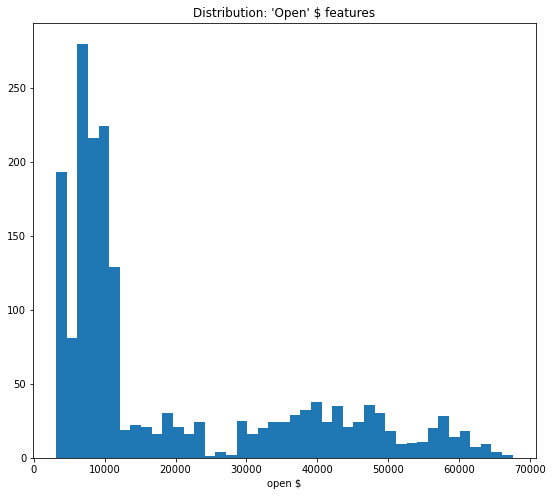

In [15]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Open'], bins = num_bins)
plt.xlabel("open $")
plt.title("Distribution: 'Open' $ features")
plt.show()

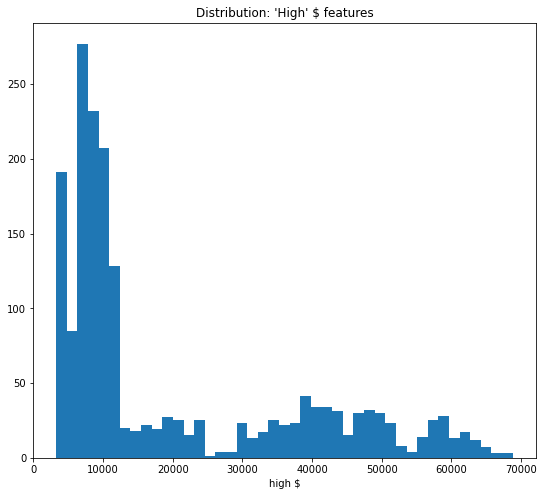

In [17]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['High'], bins = num_bins)
plt.xlabel("high $")
plt.title("Distribution: 'High' $ features")
plt.show()

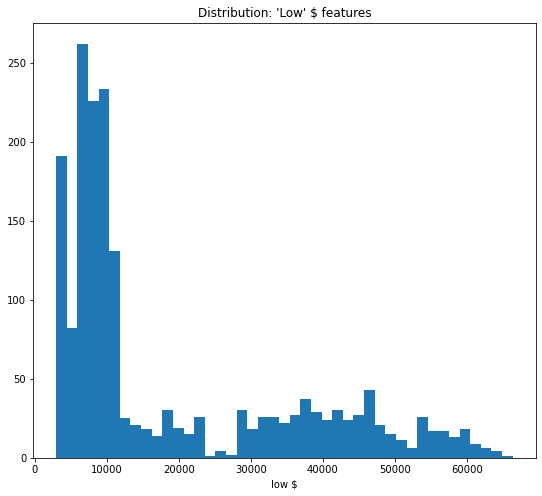

In [18]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Low'], bins = num_bins)
plt.xlabel("low $")
plt.title("Distribution: 'Low' $ features")
plt.show()

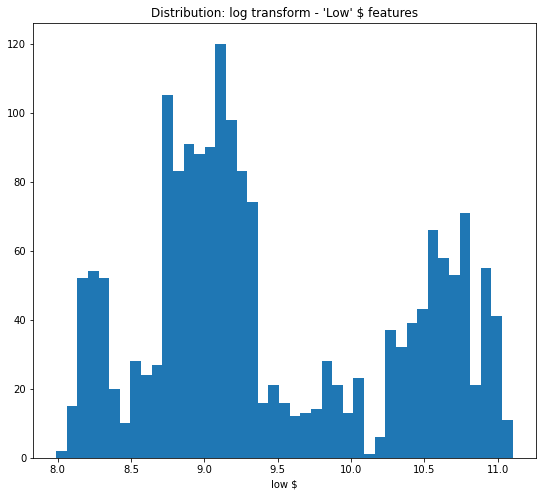

In [19]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Low']), bins = num_bins)
plt.xlabel("low $")
plt.title("Distribution: log transform - 'Low' $ features")
plt.show()

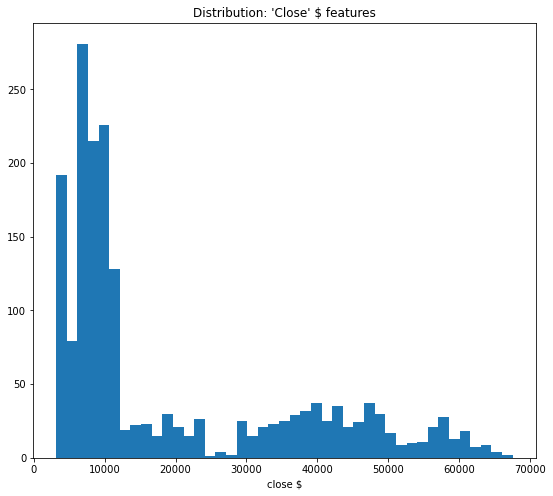

In [20]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Close'], bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: 'Close' $ features")
plt.show()

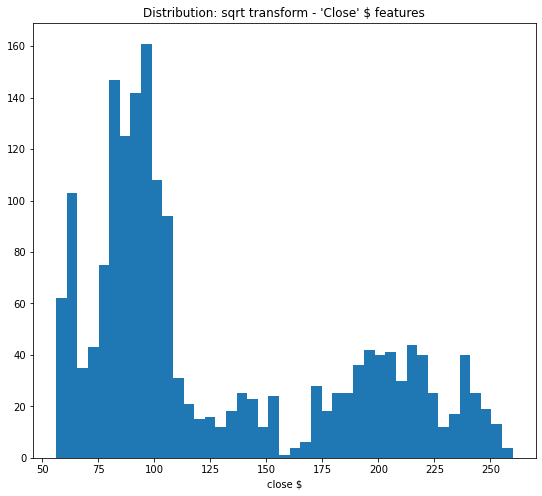

In [21]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.sqrt(data['Close']), bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: sqrt transform - 'Close' $ features")
plt.show()

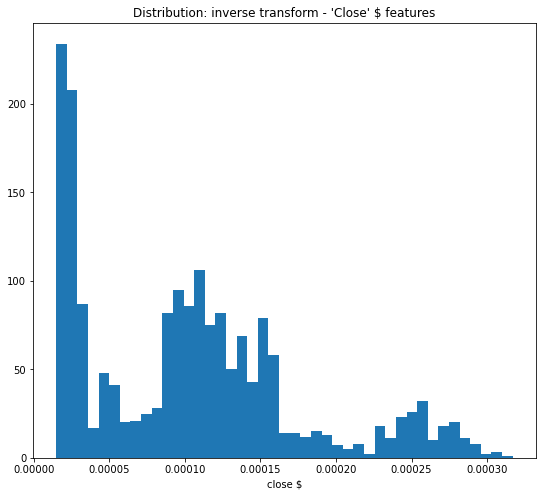

In [22]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(1 / data['Close'], bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: inverse transform - 'Close' $ features")
plt.show()

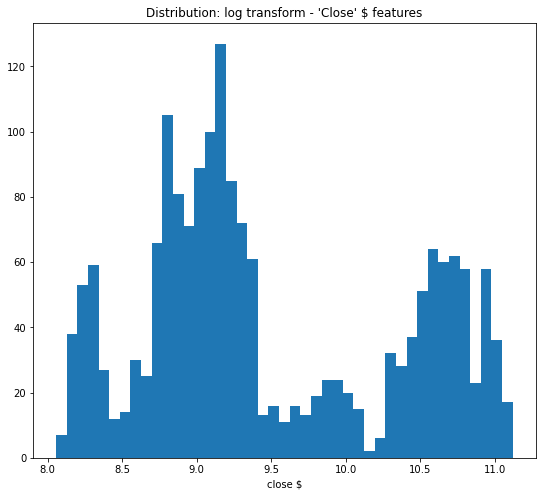

In [23]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Close']), bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: log transform - 'Close' $ features")
plt.show()

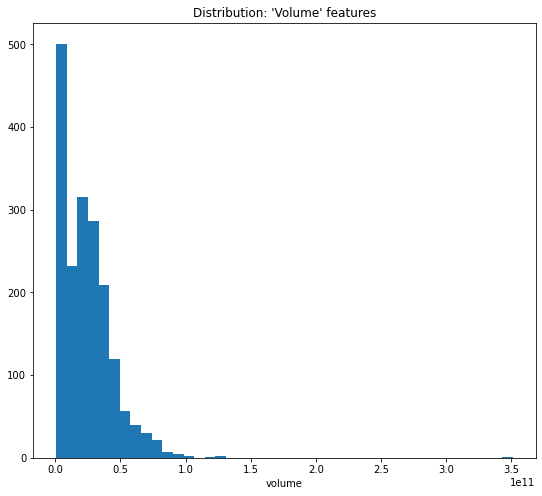

In [24]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Volume'], bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution: 'Volume' features")
plt.show()

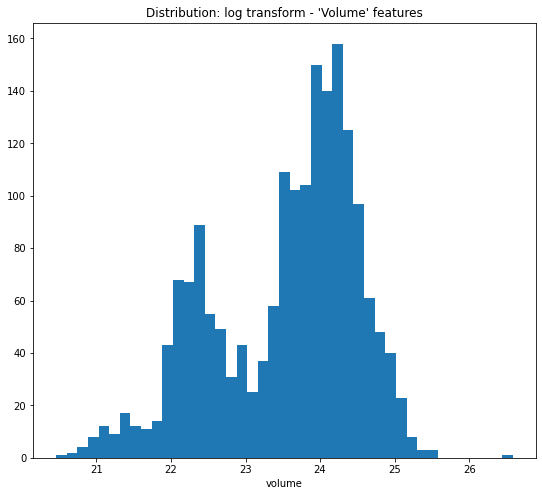

In [25]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Volume']), bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution: log transform - 'Volume' features")
plt.show()

#### Data processing has been done with ```log``` transform as it seems to work the best for this (almost) right skewed distribution.

In [15]:
# Apply log transform to all numeric features-
data_log = np.log(data.iloc[:, 1:])

In [16]:
data_log.shape

(1827, 5)

In [17]:
# Convert to float32-
data_log = data_log.astype(np.float32)

In [18]:
# Specify hyper-parameters for neural network training-
num_epochs = 100
batch_size = 256

### Split ```data``` to avoid _data leakage_

#### Train: Test split: _90:10_ 

In [19]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_log[: int(len(data_log) * 0.9)]), len(data_log[int(len(data_log) * 0.9): ])

(1644, 183)

In [20]:
# Sanity check-
len(data_log[: int(len(data_log) * 0.9)]) + len(data_log[int(len(data_log) * 0.9): ]) == len(data_log)

True

In [21]:
# Create train and test sets-
train_data = data_log[: int(len(data_log) * 0.9)]
test_data = data_log[int(len(data_log) * 0.9): ]

In [22]:
# Sanity check-
train_data.shape, test_data.shape

((1644, 5), (183, 5))

In [23]:
# Further sanity check-
train_data.iloc[-5:, :]

,Open,High,Low,Close,Volume
1639,10.517180,10.522843,10.501652,10.522843,23.645971
1640,10.522699,10.634118,10.521200,10.633470,24.104675
1641,10.633485,10.641779,10.622256,10.632030,23.701488
1642,10.632029,10.657278,10.627283,10.655197,23.504696
1643,10.655064,10.701036,10.639411,10.688309,24.078135


In [24]:
test_data.iloc[:5, :]

,Open,High,Low,Close,Volume
1644,10.688636,10.720927,10.664476,10.694633,24.222176
1645,10.694140,10.708350,10.674358,10.699615,23.869394
1646,10.699819,10.729004,10.678280,10.682012,24.193432
1647,10.682150,10.687636,10.648149,10.655091,24.017431
1648,10.655193,10.668782,10.641909,10.651229,23.622068


In [25]:
data_log.iloc[1641:1647, :]

,Open,High,Low,Close,Volume
1641,10.633485,10.641779,10.622256,10.632030,23.701488
1642,10.632029,10.657278,10.627283,10.655197,23.504696
1643,10.655064,10.701036,10.639411,10.688309,24.078135
1644,10.688636,10.720927,10.664476,10.694633,24.222176
1645,10.694140,10.708350,10.674358,10.699615,23.869394
1646,10.699819,10.729004,10.678280,10.682012,24.193432


In [27]:
# Scale with Min-max scaler-

# Initialize and train only on train dataset-
# mm_scaler = MinMaxScaler(feature_range = (-1, 1))
std_scaler = StandardScaler()
train_data = std_scaler.fit_transform(train_data.values)

# Transform test dataset with trained scaled from above-
test_data = std_scaler.transform(test_data.values)

# VAE should consequently use 'tanh' activation function in last layer!

In [28]:
# Sanity check-
train_data.shape, test_data.shape

((1644, 5), (183, 5))

In [29]:
# Sanity check-
print(f"min-max values for train dataset are: ")
for col in range(train_data.shape[1]):
    print(f"{col}; min = {train_data[:, col].min():.4f} &"
          f" max = {train_data[:, col].max():.4f}")

min-max values for train dataset are: 
0; min = -1.5777 & max = 2.0300
1; min = -1.5632 & max = 2.0165
2; min = -1.6380 & max = 2.0513
3; min = -1.5838 & max = 2.0287
4; min = -3.0130 & max = 3.0836


In [30]:
# Sanity check-
print(f"min-max values for test dataset are: ")
for col in range(test_data.shape[1]):
    print(f"{col}; min = {test_data[:, col].min():.4f} &"
          f" max = {test_data[:, col].max():.4f}")

min-max values for test dataset are: 
0; min = 0.5353 & max = 1.6138
1; min = 0.5265 & max = 1.5955
2; min = 0.4862 & max = 1.6449
3; min = 0.5340 & max = 1.6124
4; min = -0.1422 & max = 1.4843


In [31]:
def split_series_multivariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep and multivariate
    output time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        # past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [32]:
# Define hyper-parameters for Seq2Seq modeling:

# look-back window size-
n_past = 50

# number of future steps to predict for-
n_future = 10

# number of features used-
n_features = data_log.shape[1]

In [33]:
print(f"Training LSTM encoder-decoder architecture with: look back = {n_past},"
      f" look ahead = {n_future} using {n_features} attributes")

Training LSTM encoder-decoder architecture with: look back = 50, look ahead = 10 using 5 attributes


In [34]:
# Split into training and testing sets for supervised task-
X_train, y_train = split_series_multivariate(train_data, n_past, n_future)
X_test, y_test = split_series_multivariate(test_data, n_past, n_future)

In [35]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1585, 50, 5), y_train.shape: (1585, 10, 5)
X_test.shape: (124, 50, 5), y_test.shape: (124, 10, 5)


In [36]:
# Convert to float-32 values-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [37]:
print(f"One training epoch has {int(X_train.shape[0] / batch_size)} steps and"
      f" one validation epoch has {int(X_test.shape[0] / batch_size)} steps"
     )

One training epoch has 6 steps and one validation epoch has 0 steps


In [ ]:
# Create TF train and test dataset to iterate over-
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = batch_size, drop_remainder = True)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size = batch_size, drop_remainder = True)

In [ ]:
# Sanity check-
# x, y = next(iter(train_dataset))
# x.shape, y.shape

In [ ]:
# x_t, y_t = next(iter(test_dataset))
# x_t.shape, y_t.shape

In [ ]:
# del x, y, x_t, y_t

In [38]:
del train_data, test_data, data

### LSTM Encoder-Decoder architecture for Seq2Seq Time-Series Modelling

LSTM encoder's output is a _fixed-size vector_ that represents the internal representation of the input sequence (for the last input time sequence). The number of memory cells in this layer defines the length of this fixed-sized vector. The output of this encoder is a fixed-size vector that represents the internal representation of the input sequence (last time step).

The encoder will produce a 2-D matrix of outputs, where the length (second dimension) is defined by the number of memory cells in the last LSTM layer. The decoder is an LSTM layer that expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length according to the problem.

We can solve this problem by using a ```RepeatVector``` layer. This layer simply repeats the provided 2D input multiple times to create a 3D output.
The ```RepeatVector``` layer can be used like an adapter to fit the encoder and decoder parts of the network together. We can configure the ```RepeatVector``` to repeat the fixed length vector one time for each time step in the output sequence.


__Summary:__

1. The ```RepeatVector``` is used as an adapter to fit the (learned internal) fixed-sized 2D output/representation of the encoder to the differing length and 3D input expected by the decoder.

1. The ```TimeDistributed``` wrapper allows the same output layer to be reused for each element in the output sequence.


In [39]:
def LSTM_Encoder():
    # Define LSTM encoder-
    model_encoder = Sequential()
    model_encoder.add(
        LSTM(
            units = 256, input_shape = (n_past, n_features),
            return_sequences = True, activation = tf.keras.activations.tanh
            )
    )
    model_encoder.add(
        LSTM(
            units = 256, return_sequences = 128,
            activation = tf.keras.activations.tanh
        )
    )
    model_encoder.add(
        LSTM(
            units = 128, return_sequences = 128,
            activation = tf.keras.activations.tanh
        )
    )
    model_encoder.add(
        LSTM(units = 64, activation = tf.keras.activations.tanh)
    )
    
    return model_encoder


In [40]:
def LSTM_Decoder():
    # Define LSTM decoder-
    model_decoder = Sequential()
    model_decoder.add(RepeatVector(n = n_future))
    model_decoder.add(
        LSTM(
            units = 64, return_sequences = True,
            activation = tf.keras.activations.tanh
        )
    )
    model_decoder.add(
        LSTM(
            units = 128, return_sequences = True,
            activation = tf.keras.activations.tanh
        )
    )
    model_decoder.add(
        LSTM(
            units = 256, return_sequences = True,
            activation = tf.keras.activations.tanh
        )
    )
    model_decoder.add(
        LSTM(
            units = 256, return_sequences = True,
            activation = tf.keras.activations.tanh
            )
    )
    model_decoder.add(
        TimeDistributed(Dense(units = n_features, activation = None))
    )
    
    return model_decoder


In [41]:
class LSTM_Encoder_Decoder(Model):
    def __init__(
        self, look_ahead,
        look_back, num_features
    ):
        super(LSTM_Encoder_Decoder, self).__init__()
        
        self.look_ahead = look_ahead
        self.look_back = look_back
        self.num_features = num_features
        
        self.lstm_encoder = LSTM_Encoder()
        self.lstm_decoder = LSTM_Decoder()
    
    
    def call(self, x):
        x_enc = self.lstm_encoder(x)
        x_op = self.lstm_decoder(x_enc)
        return x_op
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x_enc = self.lstm_encoder(x)
        print(f"LSTM encoder (learned internal representation) output: {x_enc.shape}")
        x_op = self.lstm_decoder(x_enc)
        print(f"LSTM decoder output: {x_op.shape}")
        return None


In [42]:
# Initialize an instance of LSTM encoder-decoder architecture for Seq2Seq modelling-
model = LSTM_Encoder_Decoder(
    look_ahead = n_past, look_back = n_future,
    num_features = n_features
)

2022-08-24 09:19:14.592555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 09:19:14.595018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:19:14.595259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:19:14.595460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [47]:
# Sanity check-
x = X_train[:batch_size, :, :]
y = y_train[:batch_size, :, :]

In [48]:
# x_enc = model_encoder(x)
pred = model(x)

In [49]:
pred.shape, y.shape, x.shape

(TensorShape([256, 10, 5]), (256, 10, 5), (256, 50, 5))

In [50]:
model.shape_computation(x)

Input shape: (256, 50, 5)
LSTM encoder (learned internal representation) output: (256, 64)
LSTM decoder output: (256, 10, 5)


In [51]:
del x, y, pred

### Define _Bi-directional_ LSTM architecture

In [ ]:
"""
# Encoder-
encoder_inputs_bi = Input(shape = (n_past, n_features))
encoder_l1_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        return_state = True, activation = tf.keras.activations.tanh
    )
)
encoder_outputs1_bi = encoder_l1_bi(encoder_inputs_bi)
encoder_states1_bi = encoder_outputs1_bi[1:]
encoder_l2_bi = Bidirectional(
    LSTM(
        100, return_state = True,
        activation = tf.keras.activations.tanh
    )
)
encoder_outputs2_bi = encoder_l2_bi(encoder_outputs1[0])
encoder_states2_bi = encoder_outputs2_bi[1:]
"""

In [ ]:
"""
# Decoder-
decoder_inputs_bi = RepeatVector(n_future)(encoder_outputs2_bi[0])

decoder_l1_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        activation = tf.keras.activations.tanh
    )
)(decoder_inputs_bi, initial_state = encoder_states1_bi)
decoder_l2_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        activation = tf.keras.activations.tanh
    )
)(decoder_l1_bi, initial_state = encoder_states2_bi)
decoder_outputs2_bi = TimeDistributed(
    Dense(units = n_features))(decoder_l2_bi)
"""

In [ ]:
# Define Bi-directional model-
# model_e2d2_bi = Model(inputs = encoder_inputs_bi, outputs = decoder_outputs2_bi) 

In [52]:
# Get model summary-
model.summary()

Model: "lstm__encoder__decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                1040128   
                                                                 
 sequential_1 (Sequential)   (256, 10, 5)              1052677   
                                                                 
Total params: 2,092,805
Trainable params: 2,092,805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define LR scheduler-
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [53]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.00001,
    patience = 20, verbose = 1,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)

In [55]:
# Compile model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    # loss = tf.keras.losses.Huber()
    loss = tf.keras.losses.MeanSquaredError()
)

In [56]:
print(f"Train LSTM encoder-decoder architecture for {num_epochs} epochs")

Train LSTM encoder-decoder architecture for 100 epochs


In [57]:
# Train model-
train_history = model.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 1,
    # callbacks = [reduce_lr, early_stopping_criterion]
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7/7 [==============================] - 6s 213ms/step - loss: 0.8113 - val_loss: 0.7973
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.5395 - val_loss: 0.4675
Epoch 3/100
7/7 [==============================] - 0s 22ms/step - loss: 0.4022 - val_loss: 0.4428
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 0.2957 - val_loss: 0.3734
Epoch 5/100
7/7 [==============================] - 0s 22ms/step - loss: 0.2115 - val_loss: 0.2804
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.1612 - val_loss: 0.3921
Epoch 7/100
7/7 [==============================] - 0s 22ms/step - loss: 0.1283 - val_loss: 0.2758
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 0.1062 - val_loss: 0.3788
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0934 - val_loss: 0.3355
Epoch 10/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0818 - val_loss: 0.3045
Epoch 11/100
7/7 [

In [58]:
# Save trained weights-
model.save_weights("Bitcoin-LSTM_E3D3_Trained.h5", overwrite = True)

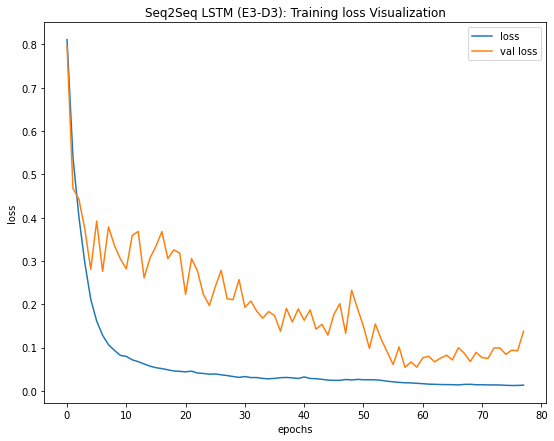

In [59]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Seq2Seq LSTM (E3-D3): Training loss Visualization")
plt.show()

In [60]:
# Initialize and Load 'best' trained weights-
trained_model = LSTM_Encoder_Decoder(
    look_ahead = n_past, look_back = n_future,
    num_features = n_features
)

In [61]:
x = X_test[:5, :]
y = y_test[:5, :]

In [62]:
pred = trained_model(x)

In [63]:
pred.shape, y.shape, x.shape

(TensorShape([5, 10, 5]), (5, 10, 5), (5, 50, 5))

In [64]:
del x, y, pred

In [65]:
trained_model.load_weights("Bitcoin-LSTM_E3D3_Trained.h5")

In [67]:
# Compile model-
trained_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    # loss = tf.keras.losses.Huber()
    loss = tf.keras.losses.MeanSquaredError()
)

In [68]:
# Compute predictions-
predictions = trained_model.predict(X_test)

In [69]:
# Sanity check-
y_test.shape, predictions.shape

((124, 10, 5), (124, 10, 5))

In [70]:
# Define two lists to contain true vs. predicted values-
true_vals = []
pred_vals = []

In [71]:
for i in range(y_test.shape[0]):
    true_vals.append(y_test[i, 0, :])

for i in range(len(predictions)):
    pred_vals.append(predictions[i, 0, :])

In [72]:
# Convert to numpy arrays-
true_vals = np.asarray(true_vals)
pred_vals = np.asarray(pred_vals)

In [73]:
# Sanity check-
true_vals.shape, pred_vals.shape

((124, 5), (124, 5))

### Remember to _inverse scale_ followed by ```exp()``` to get the final values in the correct scale.

In [75]:
# Reverse scaling-
pred_vals = std_scaler.inverse_transform(pred_vals)
true_vals = std_scaler.inverse_transform(true_vals)

In [76]:
# Inverse of log() with exp()-
pred_vals = np.exp(pred_vals)
true_vals = np.exp(true_vals)

In [77]:
# Sanity check-
pred_vals.shape, true_vals.shape

((124, 5), (124, 5))

In [78]:
pred_vals.min(), pred_vals.max()

(20524.287, 41282190000.0)

In [79]:
true_vals.min(), true_vals.max()

(17708.623, 70388850000.0)

### Visualize true vs. predicted values ∀ attributes

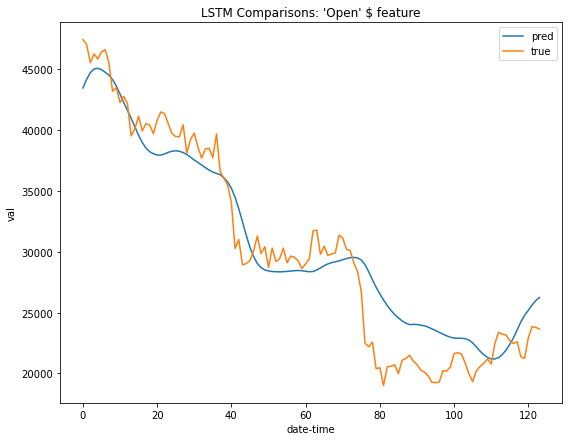

In [80]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 0].flatten(), label = 'pred')
plt.plot(true_vals[:, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Open' $ feature")
plt.legend(loc = 'best')
plt.show()

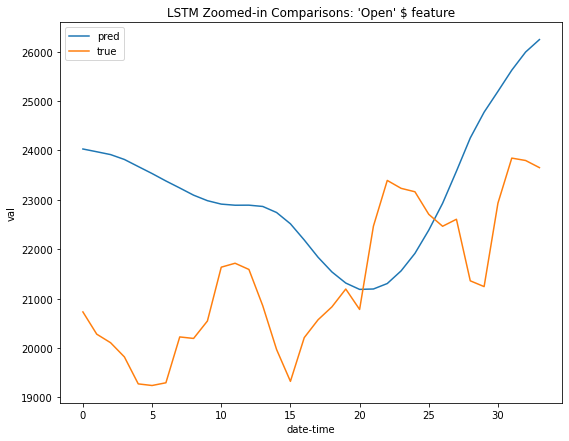

In [81]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 0].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Open' $ feature")
plt.legend(loc = 'best')
plt.show()

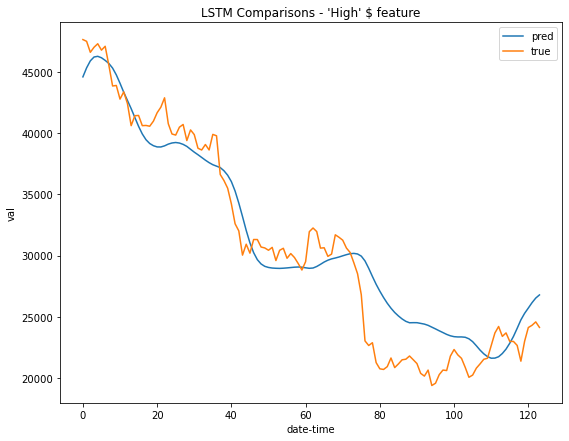

In [82]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 1].flatten(), label = 'pred')
plt.plot(true_vals[:, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons - 'High' $ feature")
plt.legend(loc = 'best')
plt.show()

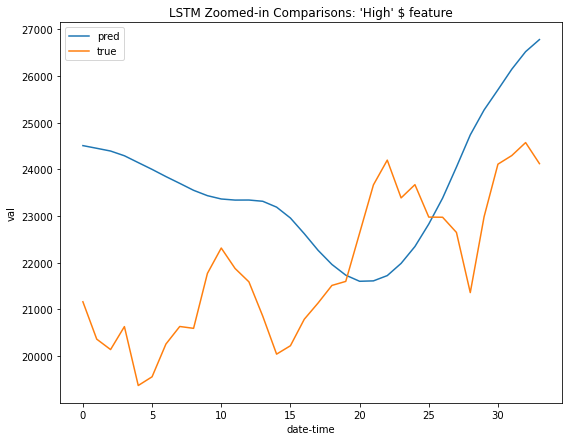

In [83]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 1].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'High' $ feature")
plt.legend(loc = 'best')
plt.show()

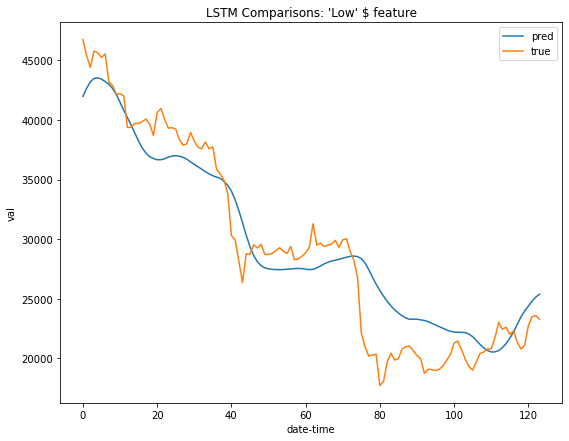

In [84]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 2].flatten(), label = 'pred')
plt.plot(true_vals[:, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Low' $ feature")
plt.legend(loc = 'best')
plt.show()

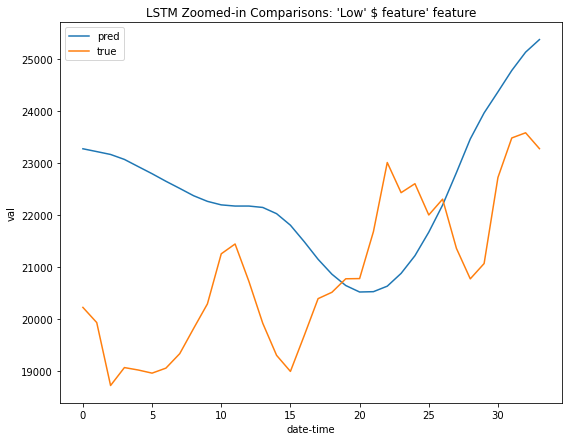

In [85]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 2].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Low' $ feature' feature")
plt.legend(loc = 'best')
plt.show()

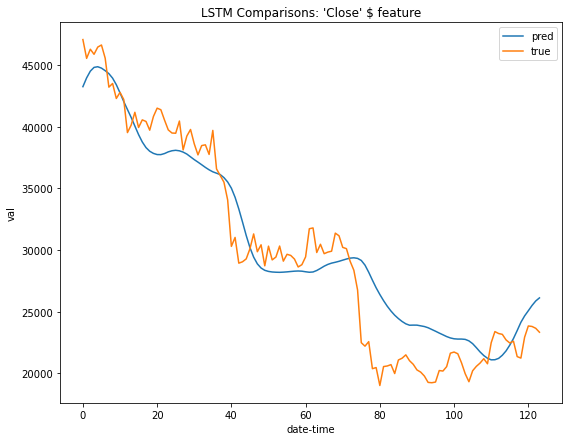

In [86]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 3].flatten(), label = 'pred')
plt.plot(true_vals[:, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Close' $ feature")
plt.legend(loc = 'best')
plt.show()

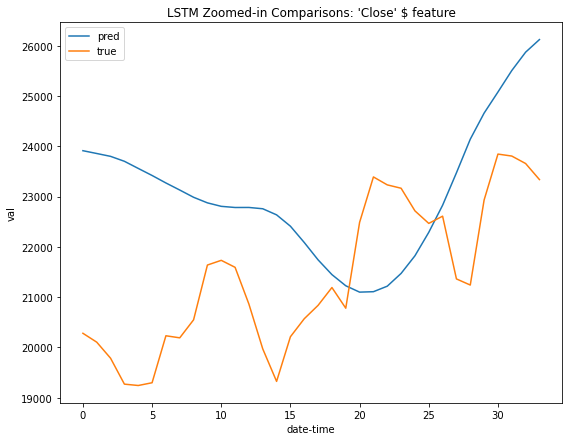

In [87]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:, 3].flatten(), label = 'pred')
plt.plot(true_vals[90:, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Close' $ feature")
plt.legend(loc = 'best')
plt.show()

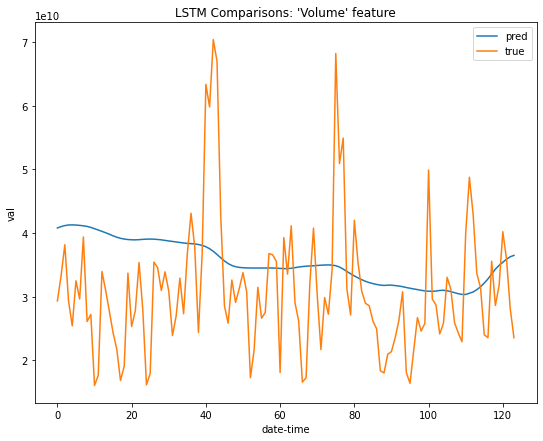

In [88]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 4].flatten(), label = 'pred')
plt.plot(true_vals[:, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Volume' feature")
plt.legend(loc = 'best')
plt.show()

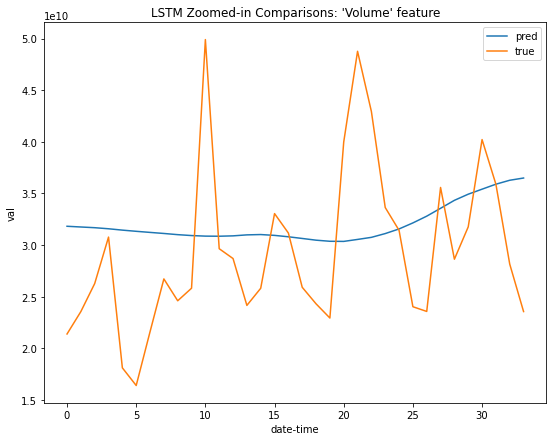

In [89]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:, 4].flatten(), label = 'pred')
plt.plot(true_vals[90:, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Volume' feature")
plt.legend(loc = 'best')
plt.show()

#### Closing remarks:

- All of the features except _Volume_ seem to be predicted well (for now).

- There appears to be a lag between the true and predicted values. The true value happens (slightly) before/ahead of the predicted values.